# Model evaluation

In this notebook, we will assess the performance of the classification model trained in notebook *'03_classification'*.

# 0. Getting setup
### Importing necessary libraries and modules

In [1]:
# PyTorch framework
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

# Model evaluation
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Basic libraries
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
import numpy as np
import random
import pathlib
import os
import time
import copy

### Set device

Setup device-agnostic code for our models and data to run on GPU if it's available.

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Prepare the test dataset

In [3]:
# Define the transformation steps using transforms.Compose()
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
])

# Define the data_dir
data_dir = '../datasets/Weather_Dataset_Split'

# Create the datasets using ImageFolder class
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_transforms) 
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True) 
class_names = test_dataset.classes

# Print the dataset size
print("Test dataset :", len(test_dataset))
print("Class Names:", class_names)

Test dataset : 170
Class Names: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


## 2. Load your trained model

In [4]:
class ClassificationModel(nn.Module):
    def __init__(self, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*224*224, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

The model trained in the notebook *"03_classification"* can be loaded from the directory:

```
data/ 
    models/ 
        baseline_model_WeatherDataset.pth
```

In [5]:
# Create a model  with the architecture specified by ClassificationModel class
model = ClassificationModel(output_shape = 4)
model.to(DEVICE)

# Update the model's parameters with the trained weights stored in MODEL_PATH
MODEL_PATH = '../data/models/baseline_model_WeatherDataset.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location = DEVICE))

<All keys matched successfully>

## 3. Build a testing loop

In [6]:
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient computation
with torch.no_grad():
    for test_data in test_dataloader: # Iterate over the test dataloader to get test images and labels
        test_images, test_labels = (test_data[0].to(DEVICE), 
                                    test_data[1].to(DEVICE))
        # Forward pass through the model to get predictions
        output = model(test_images)
        
        # Compute the predicted labels by taking the argmax of the softmax output
        pred_label = torch.softmax(output, dim = 1).argmax(dim = 1)

        # Append the true labels and predicted labels to their respective lists
        y_true.append(test_labels.cpu())
        y_pred.append(pred_label.cpu())

# Convert the lists of true labels and predicted labels to NumPy arrays
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

## 4. Compute metrics

### Classification report

In [7]:
# Generate the classification report and print it
report = classification_report(y_true, 
                               y_pred, 
                               target_names = ["Cloudy", "Rain", "Shine","Sunrise"], 
                               digits = 4)
print(report)

              precision    recall  f1-score   support

      Cloudy     0.7755    0.8444    0.8085        45
        Rain     0.8438    0.8182    0.8308        33
       Shine     0.9189    0.8947    0.9067        38
     Sunrise     1.0000    0.9630    0.9811        54

    accuracy                         0.8882       170
   macro avg     0.8845    0.8801    0.8818       170
weighted avg     0.8921    0.8882    0.8896       170



### Confusion matrix

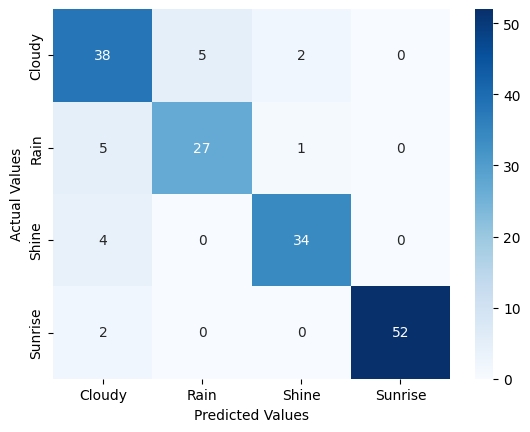

In [8]:
# Generate the confusion matrix
cmat = confusion_matrix(y_true, y_pred)

# Create a heatmap for the confusion matrix visualization
ax = sns.heatmap(cmat, annot = True, cmap = 'Blues')

# Set labels for x-axis and y-axis
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Set the labels 
ax.xaxis.set_ticklabels(['Cloudy', 'Rain', 'Shine','Sunrise'])
ax.yaxis.set_ticklabels(['Cloudy', 'Rain', 'Shine','Sunrise'])

# Display the visualization of the Confusion Matrix
plt.show()

## 5. Visualize model predictions on images from the test set

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}| True label: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)

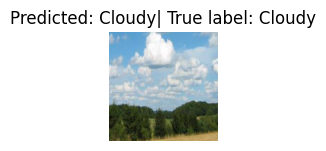

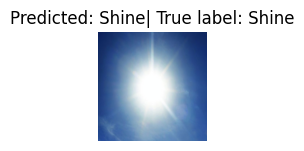

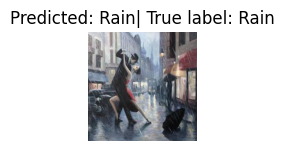

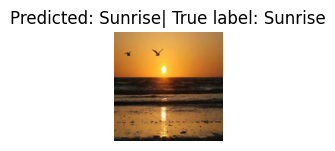

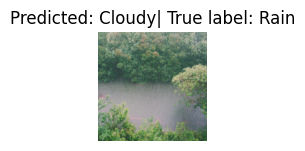

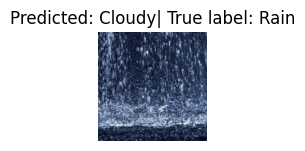

In [11]:
visualize_model(model, num_images = 6)

# EXERCISE 1: Transport dataset

Let's work with the model trained in the previous section for the classification of different types of transports (airplanes, cars, and ships). Now, we will assess the model's generalization ability. To do this, follow the steps below:

- **1.1 Prepare the test_dataset**: Begin by defining the data transform and creating the test_dataset along with the test_dataloader. 

- **1.2. Load the model**: In case you haven't finished the exercise mentioned in notebook "03_classification," you can utilize the model located in the following directory:

```
data/ 
    models/ 
        baseline_model_TransportDataset.pth
```

- **1.3. Obtain model's evaluation metrics**: Obtain the model [confusion matrix (normalizing the values)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and the recall, precision, f1-score for each class and overall accuracy.

- **1.4. Visualize model predictions and target labels**


# EXERCISE 2: Binary classification

Imagine that you are working on a **binary classification problem** where you have the following labels and output results:

> labels = [0,1,0,0,1,1,1,0,1,0,0,0,1,0,1,1,0,1,1]

> predictions = [0,0,0,0,1,1,1,0,1,0,0,1,1,0,1,1,1,0,0]

2.1) Determine the true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). Treat the class labeled as (1) as the positive and the one labeled as (0) as the negative. Hint: Use sklearn.metrics.confusion_matrix.

2.2) Use the values from the confusion matrix to compute the accuracy, recall, precision, specificity, and F1-Score. Compare these results with the ones obtained using the classification report function and the  specific functions for each metric ([recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html), [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) and  [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html))

2.3) Analyze the table generated with the classification report method. Determine the specificity from it. Explain how you can do it. Also, explain the meaning of "macro avg" and "weighted avg.". In which case would both measures give the same result?

2.4) Obtain the ROC curve and AUC (Area Under the Curve) using the provided model probabilities. In this case, when p>0.5, the prediction is 1, and when p<0.5, the prediction is 0.
>outputs = [0.34,0.49,0.12,0.23,0.67,0.92,0.85,0.46,0.73,0,0,1,1,0.42,0.61,0.53,0.55,0.35,0.48]
